# BERT BINARY

This notebook demonstrates the process of fine-tuning two BERT models for a sequence classification task

#### Steps
1. **Configuration and Setup**:
    - Define model configurations and hyperparameters.
    - Initialize the tokenizer and model configurations.

2. **Data Preparation**:
    - Load and preprocess the dataset.
    - Encode the data using the BERT tokenizer.
    - Create DataLoader objects for training, validation, and test sets.

3. **Model Training**:
    - Define utility functions for training and evaluation.
    - Implement early stopping to prevent overfitting.
    - Train the model for a specified number of epochs, evaluating on the validation set after each epoch.

4. **Evaluation**:
    - Evaluate the model on the validation set.
    - Calculate and display metrics such as accuracy, confusion matrix, and classification report.
    - Save the trained model for future use.

#### Key Hyperparameters
- **Learning Rate (`LR`)**: Controls the step size during optimization.
- **Batch Size (`BATCH_SIZE`)**: Number of samples processed before the model's internal parameters are updated.
- **Epochs (`EPOCHS`)**: Number of times the entire dataset is passed through the model.
- **Dropout Probabilities (`hidden_dropout_prob` and `attention_probs_dropout_prob`)**: Probabilities of dropping units during training to prevent overfitting.

#### Important Notes
- **Early Stopping**: Implemented to halt training if the validation loss does not improve for a certain number of epochs.
- **Gradient Clipping**: Used to prevent exploding gradients by capping the gradient values during backpropagation.
- **Model Saving**: The trained model is saved at the end of the training process for future inference or fine-tuning.


- bert-base-uncased (model_1)
- bert-large-whole-word-masking (model_2)

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

from tqdm.notebook import tqdm
from colorama import Fore, Style
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Model Configuration

In [3]:
# Dictionary for bert-base-uncased
model_1_info = {
    "NAME": "bert-base-uncased",
    "BATCH_SIZE": 32,
    "EPOCHS": 3,
    "LR": 3e-05,
    "HID_DP": 0.3,
    "ATT_DP": 0.3
}

# Dictionary for bert-large-whole-word-masking
model_2_info = {
    "NAME": "bert-large-uncased-whole-word-masking",
    "BATCH_SIZE": 64,
    "EPOCHS": 4,
    "LR": 5e-05,
    "HID_DP": 0.3,
    "ATT_DP": 0.3
}

In [4]:
MAX_LEN = 70    # From BERT-like_grids.ipynb

# Early stopping parameters
MIN_DELTA = 20
PATIENCE = 2

In [5]:
print(torch.cuda.is_available())

True


In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:1


In [7]:
#pip install iProgress
#pip install ipywidgets
#!pip install ipywidgets --upgrade
#!pip install ipywidgets tqdm --upgrade

## Data Preprocessing

In [8]:
# Load the train, validation and test datasets
train_df = pd.read_csv('../../data/New dataset/BERT/train_tweets_Transformers_new_binary.csv')
eval_df = pd.read_csv('../../data/New dataset/BERT/eval_tweets_Transformers_new_binary.csv')
test_df = pd.read_csv('../../data/New dataset/BERT/test_tweets_Transformers_new_binary.csv')

### Labels encoding

In [9]:
# Identify all unique labels in the training dataset
possible_labels = train_df.cyberbullying_type.unique()

# Create a dictionary to map each unique label to a numeric index
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

print(label_dict, "\n")

# Replace the text labels with numeric labels in the training dataframe
# and ensure the column is inferred as the correct data type without copying the data
train_df['label'] = train_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)

# Do the same replacement for the validation and test dataframes
eval_df['label'] = eval_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)
test_df['label'] = test_df.cyberbullying_type.replace(label_dict).infer_objects(copy=False)

train_df.head()

{0: 0, 1: 1} 



,tweet_text,cyberbullying_type,label
0,nah dont need explain hope ur well how r u,0,0
1,hahahaha,0,0
2,kkkkkkkkkkk eu e a mamae zombando com o que a ...,0,0
3,which was my first choice.,0,0
4,'bezza?' 'omg this is bezza' 'becca?' this is ...,0,0


## Define utility functions to prepare the data

In [10]:
# Encode the data using the specified tokenizer
def encode_data(df, tokenizer):
    encoded_data = tokenizer.batch_encode_plus(
        df.tweet_text.values,               # The tweet texts to be encoded
        add_special_tokens = True,          # Add [CLS] and [SEP] special tokens
        return_attention_mask = True,       # Return attention masks
        max_length = MAX_LEN,
        padding = 'max_length',             # Pad to the maximum length
        truncation = True,                  # Truncate to the maximum length
        return_tensors = 'pt'               # Return PyTorch tensors
    )
    return encoded_data

In [11]:
# Encodes the data and create DataLoader objects for training and validation datasets
def get_dataloaders(tokenizer, batch_size):

    # Encode data
    encoded_data_train = encode_data(train_df, tokenizer)
    encoded_data_val = encode_data(eval_df, tokenizer)
    encoded_data_test = encode_data(test_df, tokenizer)

    # Extract input_ids_train and attention_masks_train; convert labels into tensors
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_df.label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(eval_df.label.values)

    input_ids_test = encoded_data_test['input_ids']
    attention_masks_test = encoded_data_test['attention_mask']
    labels_test = torch.tensor(test_df.label.values)

    # Create datasets based on tensors, combining the input IDs, attention masks, and labels for the training set into a TensorDataset.
    # This allows the data to be easily accessed and used by PyTorch's DataLoader.
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
    dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

    # Create DataLoader for the training set with random sampling
    dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

    # Create DataLoader for the validation set and test set with sequential sampling
    dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

    dataloader_test = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=batch_size)

    return dataloader_train, dataloader_validation, dataloader_test

## Define utility functions for compute the metrics

In [12]:
# Calculate the accuracy for each class
# Parameters
# - predictions: predicted values from the model
# - labels: true labels from the dataset
def accuracy_per_class(predictions, labels):

    # Create an inverse label dictionary to map numeric labels back to their original class names
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    # Flatten the predictions and labels
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate and print the accuracy for each class
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]    # Predictions for the current class
        y_true = labels_flat[labels_flat==label]    # True labels for the current class
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Calculate the overall accuracy of the predictions
def calculate_accuracy(predictions, true_vals):
    # Flatten the predictions and labels
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()

    # Calculate and return the accuracy score
    return accuracy_score(labels_flat, preds_flat)

## Training

In [13]:
#Train the model for one epoch.
def train_one_epoch(model, history, dataloader_train, optimizer):

    # Set the model to training mode
    model.train()

    # Initialize progress bar for training
    train_progress = tqdm(dataloader_train, desc="Training", leave=False, disable=False)
    loss_train_total = 0
    correct_train, total_train = 0, 0

    for batch in train_progress:

        # Zero the gradients
        model.zero_grad()

        # Move batch to the specified device
        batch = tuple(b.to(device) for b in batch)

        # Prepare inputs for the model
        inputs = {'input_ids':    batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2].long(),
                }

        # Forward pass: compute predictions and loss
        outputs = model(**inputs)

        # Get the loss from the outputs
        loss = outputs[0]
        loss_train_total += loss.item()

        # Backward pass: compute the gradients
        loss.backward()

        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update progress bar
        train_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Calculate the number of correct predictions and total samples
        _, preds = torch.max(outputs[1], dim=1)
        correct_train += torch.sum(preds == inputs['labels'])
        total_train += len(inputs['labels'])

    # Calculate the average training loss and accuracy
    loss_train_avg = loss_train_total / len(dataloader_train)
    train_acc = correct_train.double() / total_train
    tqdm.write(f'Average Training loss: {loss_train_avg}')

    # Append metrics to history
    history['train_loss'].append(loss_train_avg)
    history['train_acc'].append(train_acc)

    return loss_train_avg, history

In [14]:
# Evaluate the model for one epoch on the validation set
def eval_one_epoch(model, history, dataloader_val):

    # Set the model to evaluation mode
    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        # Move batch to the specified device
        batch = tuple(b.to(device) for b in batch)

        # Prepare inputs for the model
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        # Forward pass: compute predictions and loss without gradient calculation
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        # Move logits and labels to CPU and convert to numpy arrays
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        predictions.append(logits)
        true_vals.append(label_ids)

    # Concatenate all predictions and true labels
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    val_accuracy = calculate_accuracy(predictions, true_vals)

    avg_val_loss = loss_val_total/len(dataloader_val)
    avg_val_acc = val_accuracy / len(dataloader_val)

    tqdm.write(f'Validation loss: {avg_val_loss}')
    tqdm.write(f'Validation Accuracy: {val_accuracy}')

    # Append metrics to history
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    return avg_val_acc, avg_val_loss, predictions, true_vals, history

In [15]:
class EarlyStopping(object):
    """
    Implements early stopping to terminate training when the validation loss stops improving.

    Parameters:
    - min_delta: minimum change in the monitored metric to qualify as an improvement
    - patience: number of epochs to wait for an improvement before stopping.
    - percentage: whether to interpret min_delta as a percentage or an absolute number.
    """

    def __init__(self, min_delta=0, patience=1, percentage=True):
        self.min_delta = min_delta
        self.patience = patience
        self.best = None            # Best metric observed so far
        self.num_bad_epochs = 0     # Counter for epochs with no improvement
        self.is_better = None       # Function to determine if the current metric is better than the best observed
        self._init_is_better(min_delta, percentage)     # Initialize the comparison function

    def step(self, metrics):
        if self.best is None:
            self.best = metrics     # Initialize the best metric with the first value
            return False            # Continue training

        if not isinstance(metrics, torch.Tensor):
            metrics = torch.tensor(metrics)

        if torch.isnan(metrics):
            print("Error: TORCH IS NAN")
            return True

        if self.is_better(metrics, self.best):
            # If an improvement is registered, reset the counter and update the best metric
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            # If no improvement, increase the counter
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            # Stop training if the number of bad epochs exceeds patience
            print(Fore.BLUE + Style.BRIGHT + 'terminating because of early stopping!'+ Style.RESET_ALL)
            return True

        return False    # Continue training

    def _init_is_better(self, min_delta, percentage):
        if not percentage:
            # Use absolute change for comparison
            self.is_better = lambda a, best: a < best - min_delta
        else:
            # Use percentage change for comparison
            self.is_better = lambda a, best: a < best - (best * min_delta / 100)

In [16]:
def execute(model_info):

    """
    Execute the training and evaluation process for a BERT model.

    Parameters:
    - model_info: a dictionary containing model configuration such as NAME, BATCH_SIZE, EPOCHS, LR, ...

    Returns:
    - model: the trained BERT model
    - tokenizer: the tokenizer used for encoding the data
    - history: a dictionary containing the training and validation loss and accuracy history
    - dataloader_test: DataLoader for the test data
    """

    # Initialize history dictionary
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Extract model configuration from the dictionary
    name = model_info["NAME"]
    batch_size = model_info["BATCH_SIZE"]
    epochs = model_info["EPOCHS"]
    lr = model_info["LR"]
    hid_dp = model_info["HID_DP"]
    att_dp = model_info["ATT_DP"]

    tokenizer = BertTokenizer.from_pretrained(name, do_lower_case=True)

    # Get DataLoader objects for training, validation and test sets
    dataloader_train, dataloader_validation, dataloader_test = get_dataloaders(tokenizer, batch_size)

    # Initialize the BERT configuration
    config = BertConfig.from_pretrained(name,
                                    hidden_dropout_prob=hid_dp,
                                    attention_probs_dropout_prob=att_dp,
                                    num_labels=len(label_dict),
                                    output_attentions=False,
                                    output_hidden_states=False)

    model = BertForSequenceClassification.from_pretrained(name, config=config)

    optimizer = AdamW(model.parameters(), lr)

    # Move the model to the specified device
    model.to(device)

    print("\n*** Start TRAINING ***")

    early_stopping = EarlyStopping(min_delta=MIN_DELTA, patience=PATIENCE)
    train_loss, validation_loss, validation_acc = [], [], []
    total_acc_score = 0

    for i in range(0, epochs):
        print(Fore.GREEN + Style.BRIGHT + f"Epoch {i+1}" +Style.RESET_ALL)

        # Train the model for one epoch
        avg_train_loss_one_epoch, history = train_one_epoch(model, history, dataloader_train, optimizer)
        train_loss.append(avg_train_loss_one_epoch)

        # Validate the model
        epoch_acc_score, avg_val_loss_one_epoch, predictions, true_vals, history = eval_one_epoch(model, history, dataloader_validation)
        validation_loss.append(avg_val_loss_one_epoch)
        validation_acc.append(epoch_acc_score)

        total_acc_score += epoch_acc_score

        # Check for early stopping
        if early_stopping.step(avg_val_loss_one_epoch):
            print("We are at epoch:", i+1)
            break


    print("\n*** END ***")

    # Save the trained model
    model_name = model.config.name_or_path
    torch.save(model.state_dict(), f'../../data/Transformers/binary_finetuned_{model_name}.model')
    print("\tModel saved successfully!")

    # Calculate accuracy per class
    accuracy_per_class(predictions, true_vals)

    # Flatten predictions and labels for confusion matrix and classification report
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()

    # Print confusion Matrix
    print(confusion_matrix(labels_flat, preds_flat))
    print("\n\n")

    # Print classification Report
    print(classification_report(labels_flat, preds_flat))

    return model, tokenizer, history, dataloader_test

In [19]:
model_1, tokenizer_1, history_1, dataloader_test_1 = execute(model_1_info)

/home/g.russo55/HLT/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



*** Start TRAINING ***
Epoch 1


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Average Training loss: 0.3095718129147445
Validation loss: 0.219313639577311
Validation Accuracy: 0.9108433734939759
Epoch 2


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Average Training loss: 0.19177646474131654
Validation loss: 0.2522777280701587
Validation Accuracy: 0.9188755020080321
Epoch 3


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Average Training loss: 0.15563763344600315
Validation loss: 0.21851668005155472
Validation Accuracy: 0.9224899598393574
terminating because of early stopping!
We are at epoch: 3

*** END ***
	Model saved successfully!
Class: 0
Accuracy: 1116/1246

Class: 1
Accuracy: 1181/1244

[[1116  130]
 [  63 1181]]



              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1246
           1       0.90      0.95      0.92      1244

    accuracy                           0.92      2490
   macro avg       0.92      0.92      0.92      2490
weighted avg       0.92      0.92      0.92      2490



In [20]:
def show_plots(history):
    def convert_to_numpy(val):
        if isinstance(val, torch.Tensor):
            return val.cpu()
        return val

    # Extract and convert the values
    train_loss = [convert_to_numpy(t) for t in history['train_loss']]
    val_loss = [convert_to_numpy(t) for t in history['val_loss']]
    train_acc = [convert_to_numpy(t) for t in history['train_acc']]
    val_acc = [convert_to_numpy(t) for t in history['val_acc']]

    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

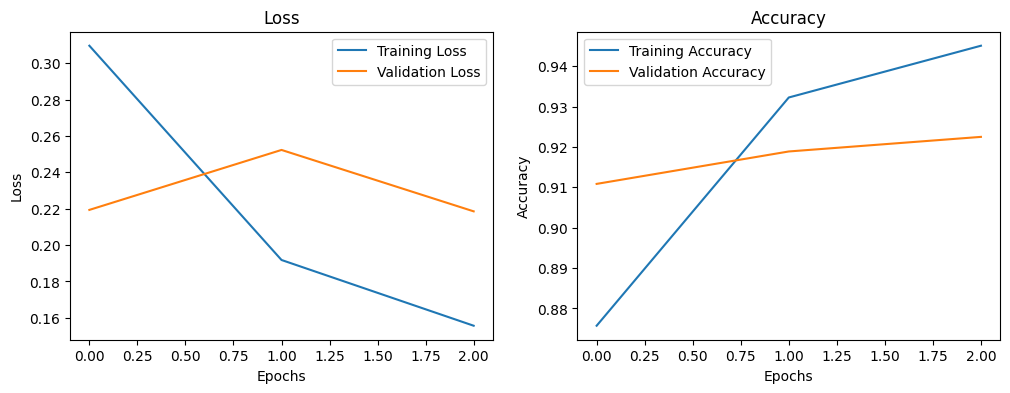

In [21]:
show_plots(history_1)

## Evaluate test set

In [26]:
def evaluate_model(model, dataloader_test):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader_test:

        input_ids, attention_masks, labels = batch

        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None,
                        attention_mask=attention_masks)

        logits = outputs.logits

        logits = torch.argmax(logits, dim=1).flatten().cpu().numpy()
        label_ids = labels.cpu().numpy()

        predictions.extend(logits)
        true_labels.extend(label_ids)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    print("\t***************\t")
    # Print confusion Matrix
    print(confusion_matrix(true_labels, predictions))
    print("\n\n")

    # Print classification Report
    print(classification_report(true_labels, predictions))

In [27]:
evaluate_model(model_1, dataloader_test_1)

Accuracy: 0.918848167539267
Precision: 0.9201736355871426
Recall: 0.918848167539267
	***************	
[[1192  146]
 [  71 1265]]



              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1338
           1       0.90      0.95      0.92      1336

    accuracy                           0.92      2674
   macro avg       0.92      0.92      0.92      2674
weighted avg       0.92      0.92      0.92      2674



## Predictions

In [28]:
def predict(text, model, tokenizer, device=device):
    model.eval()

    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

    prediction_type = next((chiave for chiave, valore in label_dict.items()
                           if valore == prediction), None)
    return prediction_type

In [30]:
def print_category(sentence):
    predicted_category = predict(sentence, model_1, tokenizer_1)
    print(f"Text: {sentence} \nPredicted Cyberbullying Category: ", end="")
    print(Fore.BLUE + Style.BRIGHT + f"{predicted_category}"+ Style.RESET_ALL)
    print("----------------")
    return

print_category("Example of a new tweet that could be cyberbullying.")
print_category("fuck you black")
print_category("i will rape you")
print_category("muslim idiot")
print_category("hello how are you")
print_category("Can anyone else said to this nigger that the dress is blue?")
print_category("I'm really happy for your birthday")
print_category("In my opinion Allah is not a real god")
print_category("I fucking hate Allah")
print_category("I appreciate Allah")
print_category("Men are better than women")
print_category("Bro, you are a Nigga!!!")
print_category("You are a shit!!!")

Text: Example of a new tweet that could be cyberbullying. 
Predicted Cyberbullying Category: 0
----------------
Text: fuck you black 
Predicted Cyberbullying Category: 1
----------------
Text: i will rape you 
Predicted Cyberbullying Category: 1
----------------
Text: muslim idiot 
Predicted Cyberbullying Category: 1
----------------
Text: hello how are you 
Predicted Cyberbullying Category: 0
----------------
Text: Can anyone else said to this nigger that the dress is blue? 
Predicted Cyberbullying Category: 1
----------------
Text: I'm really happy for your birthday 
Predicted Cyberbullying Category: 0
----------------
Text: In my opinion Allah is not a real god 
Predicted Cyberbullying Category: 0
----------------
Text: I fucking hate Allah 
Predicted Cyberbullying Category: 0
----------------
Text: I appreciate Allah 
Predicted Cyberbullying Category: 0
----------------
Text: Men are better than women 
Predicted Cyberbullying Category: 0
----------------
Text: Bro, you are a Nigga!